In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils import load_anything, get_basename, path_of, norm, float_to_uint16, care_align, quantile_image, quantile_image_minmax, hill, mip, upsample3d, iou, iou_cuda, get_best_iou
import tifffile
import torch
import torch.nn.functional as F

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from tqdm import tqdm

In [2]:
base = "_results_for_paper"

# fig.2 adversarial simulation data
## b explanation of experiment

In [3]:
# load all images needed
original00 = tifffile.imread(path_of(base, "fig2_a", "original", 0))[0]
original45 = tifffile.imread(path_of(base, "fig2_a", "original", 1))[0]
original90 = tifffile.imread(path_of(base, "fig2_a", "original", 2))[0]
label00    = tifffile.imread(path_of(base, "fig2_a", "label"   , 0))
label45    = tifffile.imread(path_of(base, "fig2_a", "label"   , 1))
label90    = tifffile.imread(path_of(base, "fig2_a", "label"   , 2))
original00 = upsample3d((norm(original00)))
original45 = upsample3d((norm(original45)))
original90 = upsample3d((norm(original90)))

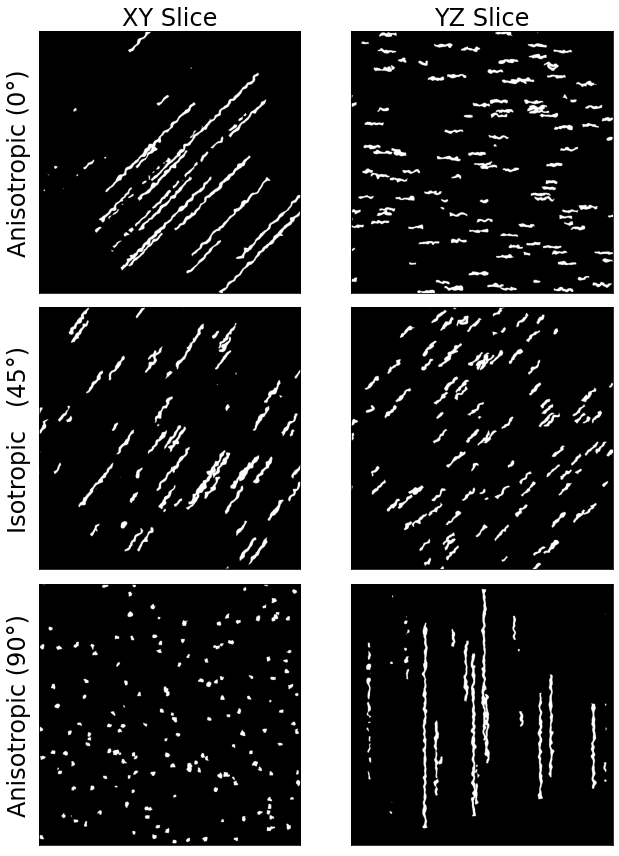

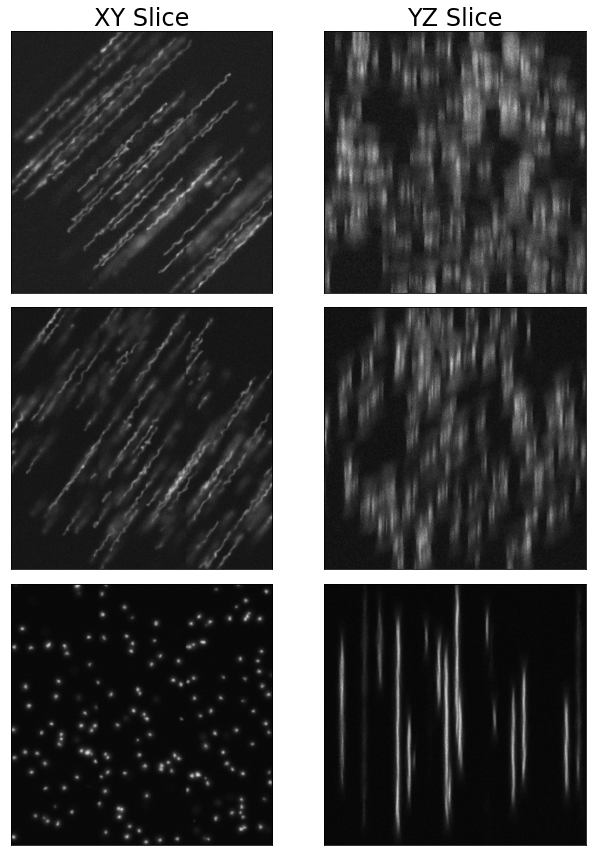

In [4]:
# functions to generate images
def figure_2_b(figures  ,
               sec0     ,
               sec1     ,
               start0   ,
               start1   ,
               range0   ,
               range1   ,
               x_start  ,
               x_end    ,
               y_start  ,
               y_end    ,
               figsize  ,
               fontsize ,
               figname  ,
               ):
    fig = plt.figure(figsize=figsize)
    fig.set_facecolor('white')
    gs = gridspec.GridSpec(len(figures), 2, figure=fig, wspace=0)
    for i, figure in enumerate(figures):
        ax = fig.add_subplot(gs[i, 0])
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(label=sec0.upper()+" Slice", fontsize=fontsize)
        ax.set_ylabel(figure[1], fontsize=fontsize)
        image_to_show = mip(figure[0]  ,
                            sec=sec0   ,
                            start=start0,
                            range=range0,
                            )
        ax.imshow(image_to_show[y_start:y_end, x_start:x_end],
                  cmap="gray")
        ax = fig.add_subplot(gs[i, 1])
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(label=sec1.upper()+" Slice", fontsize=fontsize)
        image_to_show = mip(figure[0],
                    sec=sec1,
                    start=start1,
                    range=range1,
                    )
        ax.imshow(image_to_show[y_start:y_end, x_start:x_end],
                  cmap="gray")
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()
    return fig

    
sec0    = "xy"
sec1    = "yz"
start0  = 425
start1  = 425
range0  = 50
range1  = 50
x_start =  0
x_end   = -1
y_start =  0
y_end   = -1
figsize = (9, 12)
fontsize = 24

figures = [
    [label00, "Anisotropic (0\u00B0)"  ],
    [label45, "Isotropic   (45\u00B0)" ],
    [label90, "Anisotropic (90\u00B0)" ],
    ]
fig_2_b_label = figure_2_b(
    figures = figures  ,
    sec0    = sec0     ,
    sec1    = sec1     ,
    start0  = start0   ,
    start1  = start1   ,
    range0  = range0   ,
    range1  = range1   ,
    x_start = x_start  ,
    x_end   = x_end    ,
    y_start = y_start  ,
    y_end   = y_end    ,
    figsize = figsize  ,
    fontsize = fontsize,
    figname  = "_results_for_paper/fig2_a/labels.pdf"
)

figures = [
    [original00, ""],
    [original45, ""],
    [original90, ""],
    ]

fig_2_b_original = figure_2_b(
    figures = figures  ,
    sec0    = sec0     ,
    sec1    = sec1     ,
    start0  = start0   ,
    start1  = start1   ,
    range0  = range0   ,
    range1  = range1   ,
    x_start = x_start  ,
    x_end   = x_end    ,
    y_start = y_start  ,
    y_end   = y_end    ,
    figsize = figsize  ,
    fontsize = fontsize,
    figname  = "_results_for_paper/fig2_a/originals.pdf"
)


In [5]:
original00_no_noise = tifffile.imread(path_of(base, "fig2_a/no_noise", "original", 0))[0]
original45_no_noise = tifffile.imread(path_of(base, "fig2_a/no_noise", "original", 1))[0]
original90_no_noise = tifffile.imread(path_of(base, "fig2_a/no_noise", "original", 2))[0]
original00_no_noise = upsample3d((norm(original00_no_noise)))
original45_no_noise = upsample3d((norm(original45_no_noise)))
original90_no_noise = upsample3d((norm(original90_no_noise)))

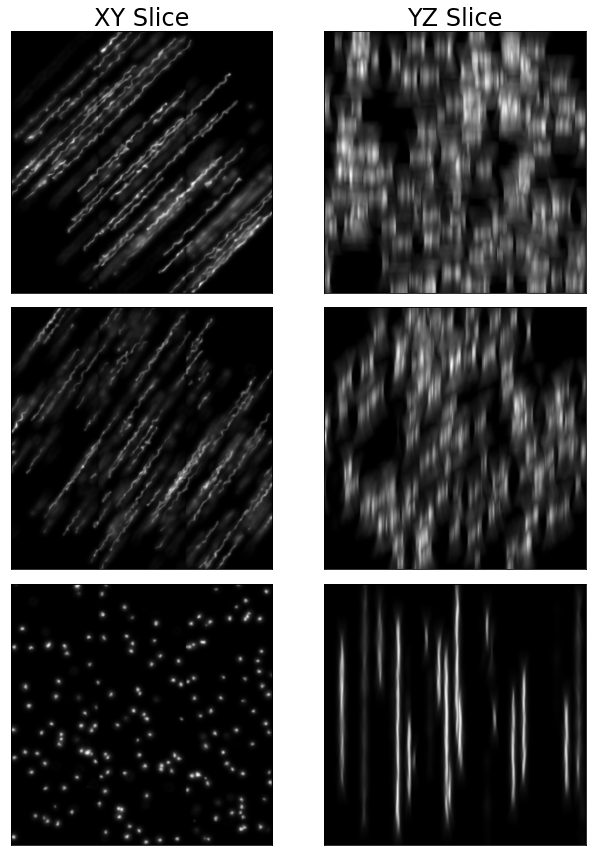

In [6]:
figures = [
    [original00_no_noise, "" ],
    [original45_no_noise, ""],
    [original90_no_noise, ""],
    ]

fig_2_b_original = figure_2_b(
    figures = figures  ,
    sec0    = sec0     ,
    sec1    = sec1     ,
    start0  = start0   ,
    start1  = start1   ,
    range0  = range0   ,
    range1  = range1   ,
    x_start = x_start  ,
    x_end   = x_end    ,
    y_start = y_start  ,
    y_end   = y_end    ,
    figsize = figsize  ,
    fontsize = fontsize,
    figname  = "_results_for_paper/fig2_a/originals.pdf"
)

In [7]:
del(
    original00_no_noise,
    original45_no_noise,
    original90_no_noise,
    original00,
    label00,
    original45,
    label45,
    original90,
    label90,
)

## c

In [8]:
def figure_2_c(figures  ,
               sec     ,
               start   ,
               range   ,
               x_start  ,
               x_end    ,
               y_start  ,
               y_end    ,
               figsize  ,
               fontsize ,
               figname  ,
               ):
    fig = plt.figure(figsize=figsize)
    fig.set_facecolor('white')
    gs = gridspec.GridSpec(3, len(figures), figure=fig, wspace=0)
    for i, figure in enumerate(figures):
        for j, img in enumerate(figure[0]):
            ax = fig.add_subplot(gs[j, i])
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                ax.set_title(label=figure[1], fontsize=fontsize)
            
            if i == 0:
                ax.set_ylabel(f"{j*45}", fontsize=fontsize)
            
            image_to_show = mip(img        ,
                                sec=sec    ,
                                start=start,
                                range=range,
                                )
            if figure[1] == "RLTV":
                image_to_show = image_to_show > figure[2][j]
            if figure[1] == "CARE":
                image_to_show = image_to_show > figure[2][j]
            if figure[1] == "neuroclear":
                image_to_show = image_to_show > figure[2][j]

            ax.imshow(image_to_show[y_start:y_end, x_start:x_end],
                      cmap="gray")

    plt.tight_layout()
    plt.savefig(figname)
    plt.show()
    return fig


In [9]:
# load all images needed
indices = [0, 1, 2]

l_original   = []
l_label      = []
l_care       = []
l_deconv     = []
l_neuroclear = []
l_tenet      = []

for idx in indices:
    original   = tifffile.imread(path_of(base, "fig2_a", "original"  , idx))[0]
    care       = tifffile.imread(path_of(base, "fig2_a", "care_new"  , idx))
    label      = tifffile.imread(path_of(base, "fig2_a", "label"     , idx))
    deconv     = tifffile.imread(path_of(base, "fig2_a", "deconv"    , idx))
    neuroclear = tifffile.imread(path_of(base, "fig2_a", "neuroclear", idx))
    tenet      = tifffile.imread(path_of(base, "fig2_a", "tenet"     , idx))[0]

    # preprocess
    original    = float_to_uint16(upsample3d((norm(original  , bit=16))))
    deconv      = (upsample3d((norm(deconv, bit=16))))
#    care        = quantile_image(, q_max=0.9999)
    care = care_align(care)
    care       /= care.max()
    neuroclear  = norm(neuroclear) 
    # store them in lists
    l_original  .append(original  )
    l_care      .append(care      )
    l_label     .append(label     )
    l_deconv    .append(deconv    )
    l_neuroclear.append(neuroclear)
    l_tenet     .append(tenet     )


In [10]:
iou_neuro = [
    get_best_iou(l_neuroclear[0], norm(l_label[0]),bins=100)[0],
    get_best_iou(l_neuroclear[1], norm(l_label[1]),bins=100)[0],
    get_best_iou(l_neuroclear[2], norm(l_label[2]),bins=100)[0],
]
iou_care =[
    get_best_iou(l_care      [0], norm(l_label[0]),bins=100)[0],
    get_best_iou(l_care      [1], norm(l_label[1]),bins=100)[0],
    get_best_iou(l_care      [2], norm(l_label[2]),bins=100)[0],
]
iou_deconv = [
    get_best_iou(l_deconv      [0], norm(l_label[0]),bins=100)[0],
    get_best_iou(l_deconv      [1], norm(l_label[1]),bins=100)[0],
    get_best_iou(l_deconv      [2], norm(l_label[2]),bins=100)[0],
]

In [11]:
# plot here
sec    = "yz"
start  = 425
range0  = 50
x_start =  0
x_end   = -1
y_start =  0
y_end   = -1
figsize = (16, 8)
fontsize = 24

figures = [
    [l_original  , "Original"         ],
    [l_label     , "GT"               ],
    [l_tenet     , "Ours"             ],
    [l_deconv    , "RLTV"        ,np.array(iou_deconv)[:, 1]
         ],
    [l_care      , "CARE"        ,np.array(iou_care)[:, 1]
         ],
    [l_neuroclear, "neuroclear"  ,np.array(iou_neuro)[:, 1]
         ],
]



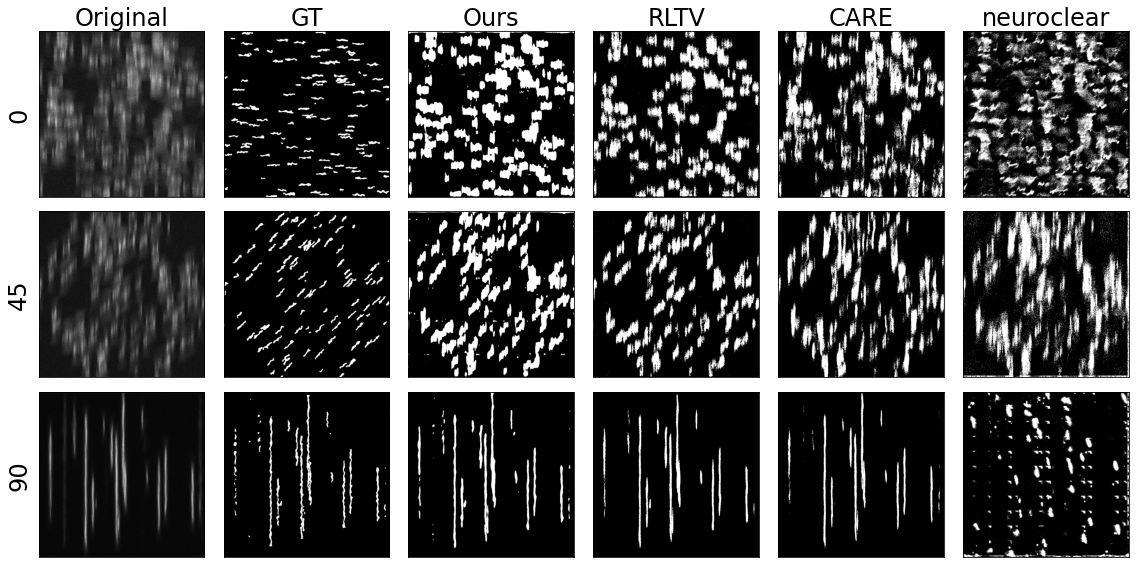

In [12]:

fig_2_c = figure_2_c(
    figures = figures  ,
    sec     = sec      ,
    start   = start    ,
    range   = range0   ,
    x_start = x_start  ,
    x_end   = x_end    ,
    y_start = y_start  ,
    y_end   = y_end    ,
    figsize = figsize  ,
    fontsize = fontsize,
    figname  = "_results_for_paper/fig2_a/labels.pdf"
)

In [13]:
iou_tenet = [iou_cuda(norm(l_tenet[0]), norm(l_label[0])),
             iou_cuda(norm(l_tenet[1]), norm(l_label[1])),
             iou_cuda(norm(l_tenet[2]), norm(l_label[2]))]
print(iou_tenet, iou_deconv,  iou_care, iou_neuro,)

[array(0.15111946), array(0.15067698), array(0.48893739)] [(0.1797633413896052, 0.12), (0.20965142661750957, 0.14), (0.4788360349091077, 0.23)] [(0.11839147469628879, 0.11), (0.12259814295678162, 0.12), (0.44648790876138916, 0.11)] [(0.05896957351228316, 0.81), (0.10610456560912691, 0.81), (0.02536071024325813, 0.31)]


# no noise

In [14]:
# load all images needed
indices = [0, 1, 2]

ln_original   = []
ln_label      = []
ln_care       = []
ln_deconv     = []
ln_neuroclear = []
ln_tenet      = []

for idx in indices:
    original   = tifffile.imread(path_of(base, "fig2_a/no_noise", "original"  , idx))[0]
    label      = tifffile.imread(path_of(base, "fig2_a", "label"     , idx))
    care       = tifffile.imread(path_of(base, "fig2_a/no_noise", "care"      , idx))
    deconv     = tifffile.imread(path_of(base, "fig2_a/no_noise", "deconv"    , idx))
    neuroclear = tifffile.imread(path_of(base, "fig2_a/no_noise", "neuroclear", idx))
    tenet      = tifffile.imread(path_of(base, "fig2_a/no_noise", "tenet"     , idx))[0]

    # preprocess
    original    = float_to_uint16(upsample3d((norm(original  , bit=16))))
    deconv      = (upsample3d((norm(deconv, bit=16))))
    care        = care_align(care)
    care       /= care.max()
    neuroclear  = norm(neuroclear) 
    # store them in lists
    ln_original  .append(original  )
    ln_care      .append(care      )
    ln_deconv    .append(deconv    )
    ln_label     .append(label     )
    ln_neuroclear.append(neuroclear)
    ln_tenet     .append(tenet     )

In [15]:
iou_n_neuro = [
    get_best_iou(ln_neuroclear[0], norm(ln_label[0]),bins=100),
    get_best_iou(ln_neuroclear[1], norm(ln_label[1]),bins=100),
    get_best_iou(ln_neuroclear[2], norm(ln_label[2]),bins=100),
]
iou_n_care =[
    get_best_iou(ln_care      [0], norm(ln_label[0]),bins=100),
    get_best_iou(ln_care      [1], norm(ln_label[1]),bins=100),
    get_best_iou(ln_care      [2], norm(ln_label[2]),bins=100),
]
iou_n_deconv = [
    get_best_iou(ln_deconv    [0], norm(ln_label[0]),bins=100),
    get_best_iou(ln_deconv    [1], norm(ln_label[1]),bins=100),
    get_best_iou(ln_deconv    [2], norm(ln_label[2]),bins=100),
]

In [16]:
sec    = "yz"
start  = 425
range0  = 50
x_start =  0
x_end   = -1
y_start =  0
y_end   = -1
figsize = (16, 8)
fontsize = 24

figures = [
    [ln_original  , "Original"         ],
    [ln_label     , "GT"               ],
    [ln_tenet     , "Ours"             ],
    [ln_deconv    , "RLTV"        ,np.array(iou_n_deconv)[:, 1]
         ],
    [ln_care      , "CARE"        ,np.array(iou_n_care)[:, 1]
         ],
    [ln_neuroclear, "neuroclear"  ,np.array(iou_n_neuro)[:, 1]
         ],
]


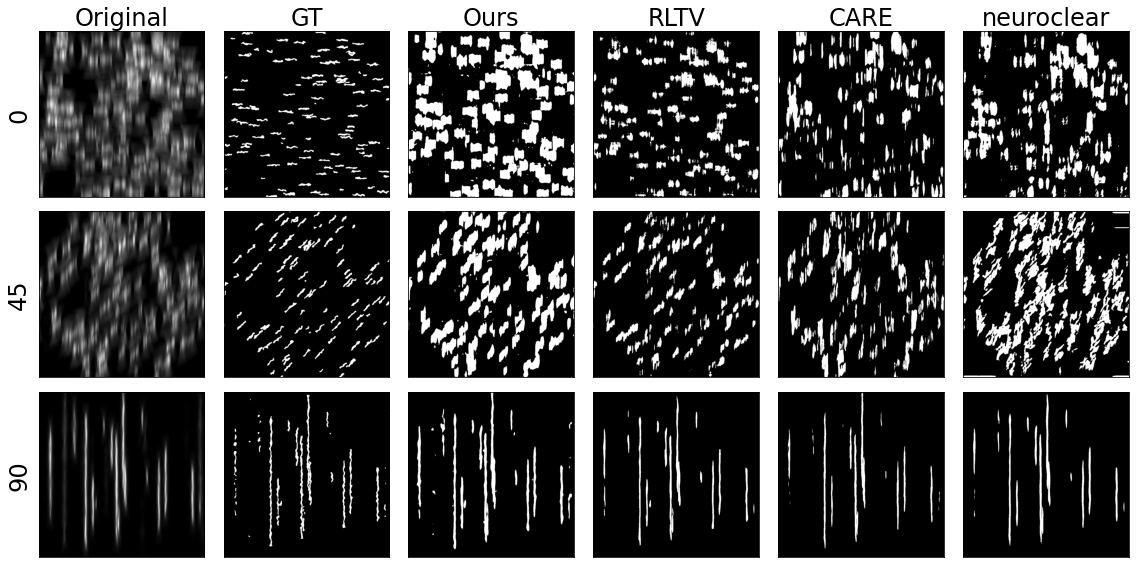

In [17]:
fig_2_c = figure_2_c(
    figures = figures  ,
    sec     = sec      ,
    start   = start    ,
    range   = range0   ,
    x_start = x_start  ,
    x_end   = x_end    ,
    y_start = y_start  ,
    y_end   = y_end    ,
    figsize = figsize  ,
    fontsize = fontsize,
    figname  = "_results_for_paper/fig2_a/labels.pdf"
)

In [18]:
iou_n_tenet = [
    iou_cuda(norm(ln_tenet[0]), norm(ln_label[0])),
    iou_cuda(norm(ln_tenet[1]), norm(ln_label[1])),
    iou_cuda(norm(ln_tenet[2]), norm(ln_label[2]))
    ]


In [19]:
print(iou_n_tenet, iou_n_deconv,  iou_n_care, iou_n_neuro,)

[array(0.13717779), array(0.16108127), array(0.41415868)] [(0.24403270107198566, 0.15), (0.27359333142345854, 0.17), (0.5077882803684789, 0.25)] [(0.10513374932957718, 0.2), (0.138784874175576, 0.18), (0.4171037822368876, 0.14)] [(0.13031933304910898, 0.71), (0.04140587228264935, 0.15), (0.47323268190221757, 0.69)]


## e angle-wise IoU scores

In [56]:
np.array(iou_n_tenet)

array([0.13717779, 0.16108127, 0.41415868])

In [146]:
ious_ = [
    iou_deconv   ,
    iou_care     ,
    iou_neuro    ,
        ]
iou_noise = np.concatenate([
    np.array(iou_tenet)[None],
    np.array(ious_)[:, :, 0],
    ])

In [147]:
ious_ = [
    iou_n_deconv   ,
    iou_n_care     ,
    iou_n_neuro    ,
        ]
iou_no_noise = np.concatenate([
    np.array(iou_n_tenet)[None],
    np.array(ious_)[:, :, 0],
                ])

In [148]:
np.stack([iou_noise,iou_no_noise], axis=0)


array([[[0.15111946, 0.15067698, 0.48893739],
        [0.17976334, 0.20965143, 0.47883603],
        [0.11839147, 0.12259814, 0.44648791],
        [0.05896957, 0.10610457, 0.02536071]],

       [[0.13717779, 0.16108127, 0.41415868],
        [0.2440327 , 0.27359333, 0.50778828],
        [0.10513375, 0.13878487, 0.41710378],
        [0.13031933, 0.04140587, 0.47323268]]])

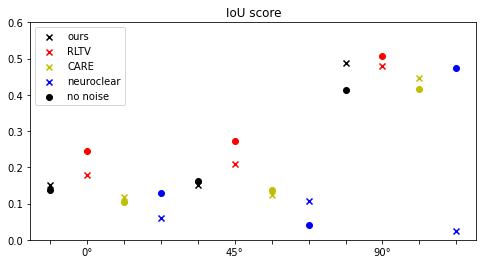

In [153]:
arr1=iou_noise.transpose(1,0).flatten()
arr2=iou_no_noise.transpose(1,0).flatten()

fig, ax = plt.subplots(figsize=(8, 4))

label = [
         "ours",
         "RLTV",
         "CARE",
         "neuroclear",
         ]
cs = ["black","r","y","b"]
# Flatten the arrays and create x and y
for i in range(12):
    ax.scatter(i, arr1[i], c=cs[i%4], marker='x', label=f'{label[i%4]}' if i//4 == 0 else None)

# Plot the second array
for i in range(12):
    ax.scatter(i, arr2[i], c=cs[i%4], marker='o', label=f'no noise' if i == 0 else None)

# Set labels and title
ax.set_title('IoU score')

# Add legend
ax.legend()
ax.set_xticks(np.arange(12))
ax.set_xticklabels(["", "0\u00B0","","", "","45\u00B0","","","", "90\u00B0","","",])
ax.set_ylim(0, 0.6)

plt.show()